In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from sklearn.model_selection import KFold
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, models, transforms


import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Define the module path so that we can call our own helper functions
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utilities.utils import get_image_paths

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 2.0-Model-Selection

The purpose of this notebook is for evaluating a set of pretrained models through cross validation, to assess the generalization capaibility of the selected models. No augmentation will be applied at this point.



## Load dataset

In [3]:
data_dir = os.path.join(module_path, "data", "processed")


In [4]:
# Dataset class
class AgeDataset(Dataset):
    def __init__(self, image_paths, ages, transform=None):
        self.image_paths = image_paths
        self.ages = ages
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # image = Image.open(self.image_paths[idx]).convert('RGB')
        image = read_image(self.image_paths[idx])
        image = image.float() / 255.0
        if self.transform:
            image = self.transform(image)
        age = self.ages[idx]
        return image, age

In [5]:
# Data resizing and normalization for training. No augmentation just yet.
# data_transforms = {
#     "train": transforms.Compose([
#         transforms.Resize((224,224)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.4519, 0.3799, 0.3389], [0.2496, 0.2254, 0.2166])
#     ]),
#     "val": transforms.Compose([
#         transforms.Resize((224,224)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.4519, 0.3799, 0.3389], [0.2496, 0.2254, 0.2166])
#     ]),
# }
        
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    # transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

In [6]:
mappings_path = os.path.join(module_path, "data", "mappings.csv")
mappings = pd.read_csv(mappings_path)

In [7]:
# Extract the lists from the mappings. We are taking from interrim as these images haven't been split into a train-val split yet. 
ages_list = mappings.target.to_list()
image_paths = mappings.updated_path.to_list()

In [8]:
# Create dataset object
dataset = AgeDataset(image_paths, ages_list, transform=data_transforms)


## Define the models used for K-Fold Cross-validation


Let's define a dict containing the functions to call our models. While it was originally desired to use SqueezeNet. Due to lack of time, only two models will be evaluated.

In [9]:
def get_efficientnet_b0():
    """
    Returns the EfficientB0 CNN model
        
    Returns:
        model: PyTorch pretrained EfficientB0 model
    """
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, 1)
    return model


def get_mobilenet_v3_small():
    """
    Returns the MobileNetv3_small CNN model
    
    Returns:
        model: PyTorch pretrained MobileNetv2 model
    """
    model = models.mobilenet_v3_small(pretrained=True)
    num_ftrs = model.classifier[3].in_features
    model.classifier[3] = torch.nn.Linear(num_ftrs, 1)
    return model

# def get_squeezenet():
#     """
#     Returns the SqueezeNet CNN model
    
#     Returns:
#         model: PyTorch pretrained SqueezeNet model
#     """
#     model = models.squeezenet1_0(pretrained=True)
#     model.classifier[1] = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
#     model.num_classes = 1
#     return model

# Define a dictionary to readily call the pretrained models
models_dict = {
    'efficientnet_b0': get_efficientnet_b0,
    # 'efficientnet_v2_s': get_efficientnet_v2_s,
    'mobilenet_v3_small': get_mobilenet_v3_small,
    # 'squeezenet': get_squeezenet
}


## Define the Evaluation Metrics

Since we are exploring a regression based problem (at least, initially), we will define different metrics we can use to evaluate each model.

In [10]:
def mean_absolute_error(y_true, y_pred):
    """
    Compute the mean absolute error
    
    Args:
        y_true (): True value
        y_pred (): Predicted value
    
    Returns:
        mean absolute error between y_true and y_pred
    
    """
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    """
    Compute the mean squared error
    
    Args:
        y_true (): True value
        y_pred (): Predicted value
    
    Returns:
        mean squared error of y_true and y_pred
    """
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    """
    Compute the root mean squared error
    
    Args:
        y_true (): True value
        y_pred (): Predicted value
    
    Returns:
        root mean squared error of y_true and y_pred
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_score(y_true, y_pred):
    """
    Compute the R^2 score
    
    Args:
        y_true (): True value
        y_pred (): Predicted value
    
    Returns:
        r squared score of y_true and y_pred
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)


## Training and Evaluation with K-Fold Cross-Validation

We will be assessing three different models with 5 folds and 10 epochs. While 10 epochs might not be enough, this could be increased in the future (particularly in a larger timeline due to the time-consuming nature)

In [11]:
def train_and_evaluate(model_fn, dataset, k=4): #k=5 original desire
    kf = KFold(n_splits=k, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    metrics = {
        'mae': [],
        'mse': [],
        'rmse': [],
        'r2': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold + 1}/{k}")
        
        train_subsampler = Subset(dataset, train_idx)
        val_subsampler = Subset(dataset, val_idx)
        
        trainloader = DataLoader(train_subsampler, batch_size=32, shuffle=True)
        valloader = DataLoader(val_subsampler, batch_size=32, shuffle=False)

        model = model_fn().to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(10):  # Increase number of epochs in future
            model.train()
            running_loss = 0.0
            with tqdm(trainloader, unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    tepoch.set_description(f"Epoch {epoch + 1}")
                    inputs, labels = inputs.to(device), labels.to(device).float()

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    tepoch.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(trainloader.dataset)
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

        model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in tqdm(valloader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        y_true = np.array(y_true)
        y_pred = np.array(y_pred).squeeze()

        metrics['mae'].append(mean_absolute_error(y_true, y_pred))
        metrics['mse'].append(mean_squared_error(y_true, y_pred))
        metrics['rmse'].append(root_mean_squared_error(y_true, y_pred))
        metrics['r2'].append(r2_score(y_true, y_pred))

    return metrics


In [12]:
# Evaluate each model
results = {}
for model_name, model_fn in models_dict.items():
    print(f"Evaluating {model_name}...")
    results[model_name] = train_and_evaluate(model_fn, dataset)

Evaluating efficientnet_b0...
Fold 1/4


Epoch 1: 100%|██████████| 687/687 [02:57<00:00,  3.87batch/s, loss=70.8] 


Epoch 1, Loss: 80.9918


Epoch 2: 100%|██████████| 687/687 [02:34<00:00,  4.44batch/s, loss=52.4]


Epoch 2, Loss: 41.3728


Epoch 3: 100%|██████████| 687/687 [02:32<00:00,  4.52batch/s, loss=28.5]


Epoch 3, Loss: 36.0289


Epoch 4: 100%|██████████| 687/687 [02:29<00:00,  4.58batch/s, loss=29.7]


Epoch 4, Loss: 30.8896


Epoch 5: 100%|██████████| 687/687 [02:31<00:00,  4.53batch/s, loss=17.1]


Epoch 5, Loss: 25.4681


Epoch 6: 100%|██████████| 687/687 [02:32<00:00,  4.49batch/s, loss=12]  


Epoch 6, Loss: 20.3580


Epoch 7: 100%|██████████| 687/687 [02:31<00:00,  4.54batch/s, loss=20.4]


Epoch 7, Loss: 16.9590


Epoch 8: 100%|██████████| 687/687 [02:32<00:00,  4.52batch/s, loss=22.7]


Epoch 8, Loss: 13.7194


Epoch 9: 100%|██████████| 687/687 [02:33<00:00,  4.49batch/s, loss=12.8]


Epoch 9, Loss: 11.9958


Epoch 10: 100%|██████████| 687/687 [02:32<00:00,  4.50batch/s, loss=24.6]


Epoch 10, Loss: 10.8925


Validation: 100%|██████████| 229/229 [00:32<00:00,  7.03it/s]


Fold 2/4


Epoch 1: 100%|██████████| 687/687 [02:34<00:00,  4.45batch/s, loss=68.7] 


Epoch 1, Loss: 82.4404


Epoch 2: 100%|██████████| 687/687 [02:33<00:00,  4.49batch/s, loss=46.9]


Epoch 2, Loss: 41.4314


Epoch 3: 100%|██████████| 687/687 [02:32<00:00,  4.50batch/s, loss=52.7]


Epoch 3, Loss: 35.8610


Epoch 4: 100%|██████████| 687/687 [02:31<00:00,  4.52batch/s, loss=33.3]


Epoch 4, Loss: 31.0574


Epoch 5: 100%|██████████| 687/687 [02:29<00:00,  4.59batch/s, loss=26.9]


Epoch 5, Loss: 25.8405


Epoch 6: 100%|██████████| 687/687 [02:28<00:00,  4.61batch/s, loss=13.6]


Epoch 6, Loss: 20.8556


Epoch 7: 100%|██████████| 687/687 [02:26<00:00,  4.67batch/s, loss=29.4]


Epoch 7, Loss: 16.3914


Epoch 8: 100%|██████████| 687/687 [02:25<00:00,  4.74batch/s, loss=14.6]


Epoch 8, Loss: 13.9040


Epoch 9: 100%|██████████| 687/687 [02:26<00:00,  4.69batch/s, loss=6.26]


Epoch 9, Loss: 11.9821


Epoch 10: 100%|██████████| 687/687 [02:28<00:00,  4.63batch/s, loss=10.7]


Epoch 10, Loss: 11.0534


Validation: 100%|██████████| 229/229 [00:28<00:00,  7.91it/s]


Fold 3/4


Epoch 1: 100%|██████████| 687/687 [02:25<00:00,  4.71batch/s, loss=68.4] 


Epoch 1, Loss: 80.4463


Epoch 2: 100%|██████████| 687/687 [02:26<00:00,  4.68batch/s, loss=53.7]


Epoch 2, Loss: 41.4229


Epoch 3: 100%|██████████| 687/687 [02:28<00:00,  4.63batch/s, loss=42.1]


Epoch 3, Loss: 36.3627


Epoch 4: 100%|██████████| 687/687 [02:26<00:00,  4.69batch/s, loss=26.9]


Epoch 4, Loss: 30.5026


Epoch 5: 100%|██████████| 687/687 [02:25<00:00,  4.72batch/s, loss=20.8]


Epoch 5, Loss: 24.9066


Epoch 6: 100%|██████████| 687/687 [02:28<00:00,  4.64batch/s, loss=25.9]


Epoch 6, Loss: 20.0010


Epoch 7: 100%|██████████| 687/687 [02:27<00:00,  4.65batch/s, loss=35.9]


Epoch 7, Loss: 16.2539


Epoch 8: 100%|██████████| 687/687 [02:28<00:00,  4.63batch/s, loss=14.3]


Epoch 8, Loss: 13.5892


Epoch 9: 100%|██████████| 687/687 [02:28<00:00,  4.63batch/s, loss=18.9]


Epoch 9, Loss: 11.9668


Epoch 10: 100%|██████████| 687/687 [02:30<00:00,  4.56batch/s, loss=4.7] 


Epoch 10, Loss: 10.6077


Validation: 100%|██████████| 229/229 [00:26<00:00,  8.80it/s]


Fold 4/4


Epoch 1: 100%|██████████| 687/687 [02:27<00:00,  4.67batch/s, loss=42.9] 


Epoch 1, Loss: 81.9534


Epoch 2: 100%|██████████| 687/687 [02:30<00:00,  4.57batch/s, loss=39.8]


Epoch 2, Loss: 41.9757


Epoch 3: 100%|██████████| 687/687 [02:28<00:00,  4.64batch/s, loss=50.2]


Epoch 3, Loss: 36.2034


Epoch 4: 100%|██████████| 687/687 [02:28<00:00,  4.63batch/s, loss=40.8]


Epoch 4, Loss: 31.4374


Epoch 5: 100%|██████████| 687/687 [02:27<00:00,  4.66batch/s, loss=38.2]


Epoch 5, Loss: 25.9623


Epoch 6: 100%|██████████| 687/687 [02:24<00:00,  4.75batch/s, loss=29.6]


Epoch 6, Loss: 21.0661


Epoch 7: 100%|██████████| 687/687 [02:24<00:00,  4.75batch/s, loss=29.7]


Epoch 7, Loss: 16.5093


Epoch 8: 100%|██████████| 687/687 [02:25<00:00,  4.73batch/s, loss=16.5]


Epoch 8, Loss: 14.3513


Epoch 9: 100%|██████████| 687/687 [02:25<00:00,  4.72batch/s, loss=7.5] 


Epoch 9, Loss: 12.3088


Epoch 10: 100%|██████████| 687/687 [02:25<00:00,  4.72batch/s, loss=19.4]


Epoch 10, Loss: 11.1302


Validation: 100%|██████████| 229/229 [00:29<00:00,  7.87it/s]


Evaluating mobilenet_v3_small...
Fold 1/4


Epoch 1: 100%|██████████| 687/687 [01:29<00:00,  7.72batch/s, loss=54.5] 


Epoch 1, Loss: 62.3095


Epoch 2: 100%|██████████| 687/687 [01:27<00:00,  7.89batch/s, loss=60.5]


Epoch 2, Loss: 44.6267


Epoch 3: 100%|██████████| 687/687 [01:28<00:00,  7.79batch/s, loss=47.4]


Epoch 3, Loss: 40.9503


Epoch 4: 100%|██████████| 687/687 [01:26<00:00,  7.93batch/s, loss=44.4]


Epoch 4, Loss: 35.7116


Epoch 5: 100%|██████████| 687/687 [01:27<00:00,  7.85batch/s, loss=32.1]


Epoch 5, Loss: 30.1118


Epoch 6: 100%|██████████| 687/687 [01:27<00:00,  7.81batch/s, loss=16.9]


Epoch 6, Loss: 25.8723


Epoch 7: 100%|██████████| 687/687 [01:27<00:00,  7.89batch/s, loss=17.9]


Epoch 7, Loss: 20.6090


Epoch 8: 100%|██████████| 687/687 [01:27<00:00,  7.88batch/s, loss=20.5]


Epoch 8, Loss: 17.0702


Epoch 9: 100%|██████████| 687/687 [01:27<00:00,  7.87batch/s, loss=20.9]


Epoch 9, Loss: 15.0235


Epoch 10: 100%|██████████| 687/687 [01:30<00:00,  7.58batch/s, loss=15.5]


Epoch 10, Loss: 13.7864


Validation: 100%|██████████| 229/229 [00:31<00:00,  7.22it/s]


Fold 2/4


Epoch 1: 100%|██████████| 687/687 [01:35<00:00,  7.19batch/s, loss=53.4] 


Epoch 1, Loss: 63.0077


Epoch 2: 100%|██████████| 687/687 [01:26<00:00,  7.92batch/s, loss=70.3]


Epoch 2, Loss: 45.6709


Epoch 3: 100%|██████████| 687/687 [01:26<00:00,  7.97batch/s, loss=20.2]


Epoch 3, Loss: 40.4053


Epoch 4: 100%|██████████| 687/687 [01:26<00:00,  7.96batch/s, loss=47.5]


Epoch 4, Loss: 35.7665


Epoch 5: 100%|██████████| 687/687 [01:28<00:00,  7.80batch/s, loss=45.1]


Epoch 5, Loss: 30.6977


Epoch 6: 100%|██████████| 687/687 [01:27<00:00,  7.86batch/s, loss=34.3]


Epoch 6, Loss: 25.9083


Epoch 7: 100%|██████████| 687/687 [01:28<00:00,  7.78batch/s, loss=34.9]


Epoch 7, Loss: 21.4759


Epoch 8: 100%|██████████| 687/687 [01:01<00:00, 11.22batch/s, loss=13.5]


Epoch 8, Loss: 17.9523


Epoch 9: 100%|██████████| 687/687 [00:43<00:00, 15.95batch/s, loss=25.9]


Epoch 9, Loss: 15.0757


Epoch 10: 100%|██████████| 687/687 [00:42<00:00, 16.24batch/s, loss=13.7]


Epoch 10, Loss: 13.7580


Validation: 100%|██████████| 229/229 [00:13<00:00, 17.47it/s]


Fold 3/4


Epoch 1: 100%|██████████| 687/687 [00:41<00:00, 16.39batch/s, loss=46]   


Epoch 1, Loss: 63.0173


Epoch 2: 100%|██████████| 687/687 [00:42<00:00, 16.17batch/s, loss=61.5]


Epoch 2, Loss: 45.5292


Epoch 3: 100%|██████████| 687/687 [00:42<00:00, 16.10batch/s, loss=28.6]


Epoch 3, Loss: 41.2886


Epoch 4: 100%|██████████| 687/687 [00:44<00:00, 15.61batch/s, loss=34.9]


Epoch 4, Loss: 36.4992


Epoch 5: 100%|██████████| 687/687 [00:42<00:00, 16.10batch/s, loss=46.6]


Epoch 5, Loss: 31.6066


Epoch 6: 100%|██████████| 687/687 [00:43<00:00, 15.66batch/s, loss=17]  


Epoch 6, Loss: 26.3896


Epoch 7: 100%|██████████| 687/687 [00:43<00:00, 15.97batch/s, loss=31.3]


Epoch 7, Loss: 21.9723


Epoch 8: 100%|██████████| 687/687 [00:44<00:00, 15.51batch/s, loss=24.5]


Epoch 8, Loss: 18.5323


Epoch 9: 100%|██████████| 687/687 [00:40<00:00, 16.79batch/s, loss=15.4]


Epoch 9, Loss: 15.8703


Epoch 10: 100%|██████████| 687/687 [00:43<00:00, 15.86batch/s, loss=8.37]


Epoch 10, Loss: 14.1550


Validation: 100%|██████████| 229/229 [00:11<00:00, 19.53it/s]


Fold 4/4


Epoch 1: 100%|██████████| 687/687 [00:41<00:00, 16.71batch/s, loss=50]   


Epoch 1, Loss: 63.2435


Epoch 2: 100%|██████████| 687/687 [00:42<00:00, 16.32batch/s, loss=33.3]


Epoch 2, Loss: 46.1380


Epoch 3: 100%|██████████| 687/687 [00:43<00:00, 15.71batch/s, loss=55.8]


Epoch 3, Loss: 41.4155


Epoch 4: 100%|██████████| 687/687 [00:41<00:00, 16.45batch/s, loss=38.6]


Epoch 4, Loss: 35.7544


Epoch 5: 100%|██████████| 687/687 [00:43<00:00, 15.77batch/s, loss=49.4]


Epoch 5, Loss: 31.2429


Epoch 6: 100%|██████████| 687/687 [00:42<00:00, 16.14batch/s, loss=44]  


Epoch 6, Loss: 26.1356


Epoch 7: 100%|██████████| 687/687 [00:43<00:00, 15.84batch/s, loss=34.3]


Epoch 7, Loss: 21.3707


Epoch 8: 100%|██████████| 687/687 [00:42<00:00, 16.06batch/s, loss=16.3]


Epoch 8, Loss: 18.0687


Epoch 9: 100%|██████████| 687/687 [00:42<00:00, 16.10batch/s, loss=19.3]


Epoch 9, Loss: 15.0678


Epoch 10: 100%|██████████| 687/687 [00:44<00:00, 15.50batch/s, loss=19.2]


Epoch 10, Loss: 14.2234


Validation: 100%|██████████| 229/229 [00:09<00:00, 25.34it/s]


In [13]:
# Print results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(f"Mean MAE: {np.mean(metrics['mae'])} ± {np.std(metrics['mae'])}")
    print(f"Mean MSE: {np.mean(metrics['mse'])} ± {np.std(metrics['mse'])}")
    print(f"Mean RMSE: {np.mean(metrics['rmse'])} ± {np.std(metrics['rmse'])}")
    print(f"Mean R^2: {np.mean(metrics['r2'])} ± {np.std(metrics['r2'])}")


efficientnet_b0 Results:
Mean MAE: 5.663088798522949 ± 0.41725024580955505
Mean MSE: 51.4847297668457 ± 7.6877055168151855
Mean RMSE: 7.156731605529785 ± 0.5156798362731934
Mean R^2: 0.14106282591819763 ± 0.13408371806144714

mobilenet_v3_small Results:
Mean MAE: 5.8403472900390625 ± 0.1638495922088623
Mean MSE: 53.553977966308594 ± 2.9495835304260254
Mean RMSE: 7.315273761749268 ± 0.20186598598957062
Mean R^2: 0.1066514104604721 ± 0.05912262946367264


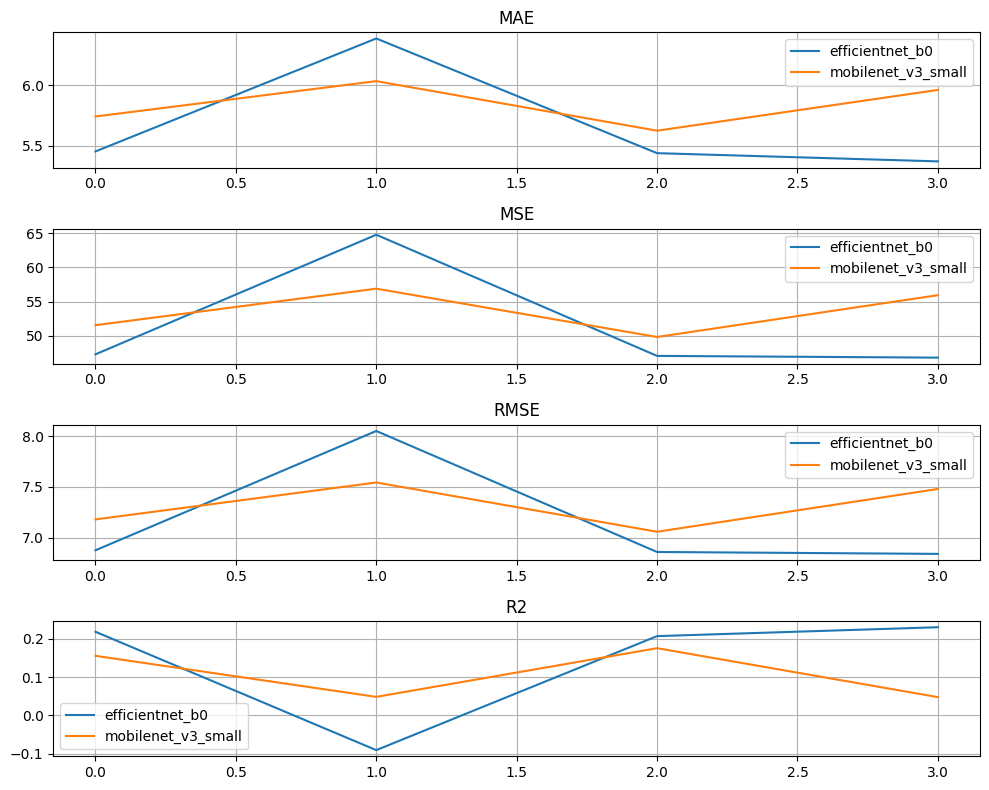

In [15]:
metrics = ['mae', 'mse', 'rmse', 'r2']
models = ['efficientnet_b0', 'mobilenet_v3_small']
num_metrics = len(metrics)
num_models = len(models)

fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 8))

for i, metric in enumerate(metrics):
    for model in models:
        axes[i].plot(results[model][metric], label=model)
    axes[i].set_title(metric.upper())
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Results
### efficientnet_b0
- MAE: The mean absolute errors across four different runs are approximately 5.45, 6.38, 5.44, and 5.37. This indicates that on average, the predictions are off by about 5.4 to 6.4 units from the actual values.
- MSE: The mean squared errors are approximately 47.29, 64.80, 47.06, and 46.80. These values are relatively high, indicating some larger errors in prediction.
- RMSE: The root mean squared errors are approximately 6.88, 8.05, 6.86, and 6.84. These values indicate the average magnitude of the errors.
- R²: The R² values are 0.22, -0.09, 0.21, and 0.23. The negative value (-0.09) suggests that for one of the runs, the model performed worse than a simple mean predictor.


### mobilenet_v3_small
- MAE: The mean absolute errors are approximately 5.74, 6.03, 5.63, and 5.96. Similar to efficientnet_b0, the predictions are off by about 5.6 to 6 units on average.
- MSE: The mean squared errors are 51.55, 56.90, 49.82, and 55.94. These values are also relatively high.
- RMSE: The root mean squared errors are approximately 7.18, 7.54, 7.06, and 7.48. These values are similar to those of efficientnet_b0, indicating the average magnitude of the errors.
- R²: The R² values are 0.16, 0.05, 0.18, and 0.05. These values indicate that the model explains a small portion of the variance in the data, but the performance is not very strong.

### Summary
Both models have similar performance metrics, with MAE, MSE, and RMSE indicating that the predictions are off by a certain range. The R² values suggest that both models have limited ability to explain the variance in the data, with some runs performing worse than others. Lower MAE, MSE, and RMSE values and higher R² values indicate better performance. efficientnet_b0 performs better than mobilenet_v3_small, however, that is a given as efficientnet has 4M parameters and mobilenet only has 1.5M with a slight performance decrease.

In [16]:
results

{'efficientnet_b0': {'mae': [np.float32(5.454874),
   np.float32(6.3838015),
   np.float32(5.4406343),
   np.float32(5.373046)],
  'mse': [np.float32(47.285225),
   np.float32(64.79692),
   np.float32(47.05587),
   np.float32(46.800907)],
  'rmse': [np.float32(6.8764253),
   np.float32(8.049653),
   np.float32(6.8597283),
   np.float32(6.841119)],
  'r2': [np.float32(0.21813554),
   np.float32(-0.09074116),
   np.float32(0.20681792),
   np.float32(0.230039)]},
 'mobilenet_v3_small': {'mae': [np.float32(5.742283),
   np.float32(6.0329943),
   np.float32(5.625449),
   np.float32(5.960664)],
  'mse': [np.float32(51.5512),
   np.float32(56.89669),
   np.float32(49.824795),
   np.float32(55.94323)],
  'rmse': [np.float32(7.1799164),
   np.float32(7.5429893),
   np.float32(7.058668),
   np.float32(7.479521)],
  'r2': [np.float32(0.15539128),
   np.float32(0.04827088),
   np.float32(0.17531377),
   np.float32(0.047629714)]}}

In [ ]:
m